# R C3X fidelity check

2019/1/6

origined by rum

---
In this code, two types of R-Toffoli gate are checked fidelity on real device

In [2]:
## import tools
## Import numpy 
import numpy as np
from numpy import pi

## import plot tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
## To plot heatmap
import seaborn as sns

## import datetime
from datetime import datetime

## Import qiskit tools
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

## import qiskit backend monitor
from  qiskit.tools.monitor import backend_monitor

## import qiskit readout error mitigation tools
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

---
# 1. Get device

In [3]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### Here to choose provider

In [4]:
## keio-internal device
# provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='keio-students')

## reservations
provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='reservations')

## open device
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

### Define the backend device

In [5]:
device = provider.get_backend("ibmq_valencia")

---
# 2. Define circuit

### 2-1. Define R-Toffoli as function

---
### R-Toffoli_m
<img src="../img/RToffoli_m.png" />

In [5]:
## define RTof function
def RTof_m(qc, c1, c2, t):
    qc.ry(pi/4, t)
    qc.cx(c2, t)
    qc.ry(pi/4, t)
    qc.cx(c1, t)
    qc.ry(-pi/4, t)
    qc.cx(c2, t)
    qc.ry(-pi/4, t)

---
### R-Toffoli_ix
<img src="../img/RToffoli_ix.png" />

In [6]:
def RTof_ix(qc, c1, c2, t):
#     qc.h(t)
#     qc.t(t)
    qc.u2(pi/4, pi, t)
    qc.cx(c2, t)
    qc.tdg(t)
    qc.cx(c1, t)
    qc.t(t)
    qc.cx(c2, t)
#     qc.tdg(t)
#     qc.h(t)
    qc.u2(0, 3*pi/4, t)

---
### Toffoli gate with one swap
<img src = "../img/Toffoli_SWAP.png" />

In [7]:
## Toffoli gate with one swap
def Toffoli_SWAP(circuit, control1,  control2, target):
    
    """
    c1, c2, t => c1, t, c2
    """
    
    circuit.h(target)
    circuit.cx(control1, target)
    circuit.tdg(target)
    circuit.cx(control2, target)
    circuit.t(target)
    circuit.cx(control1, target)
    circuit.tdg(target)
    circuit.cx(target, control2) ## SWAP
    circuit.cx(control2, target) ## SWAP
    circuit.t(control1)
    circuit.t(control2)
    circuit.cx(target ,control1)
    circuit.tdg(control1)
    circuit.h(control2)
    circuit.t(target)
    circuit.cx(target, control1)

### 2-2. Compose circuit

In [8]:
## define qubit label as num_qubits
num_qubits = len(device.configuration().gates[0].coupling_map)


## Define the list to store the circuit lists of each qubits of the processor
RTof_qc = []


## define init_list
init_list = [format(j, '04b') for j in range(16)]


## define qubit
anc, c1, c2, c3, targ = [0, 1, 2, 3, 4]

In [9]:
## repeat circuit definition for each init_list
for init in init_list:

    ## define circuit
    qr = QuantumRegister(num_qubits, "q")
    cr = ClassicalRegister(4, "c")
    circuit = QuantumCircuit(qr, cr)



    ## Initialization
    if(init[0] == '1'):
        circuit.x(qr[c1])
    if(init[1] == '1'):
        circuit.x(qr[c2])
    if(init[2] == '1'):
        circuit.x(qr[c3])
    if(init[3] == '1'):
        circuit.x(qr[int(targ)])

    ## R-C3X_m
    RTof_m(circuit, qr[c1], qr[c2], qr[anc])
    Toffoli_SWAP(circuit, qr[anc], qr[c3], qr[targ])
    RTof_m(circuit, qr[c1], qr[c2], qr[anc])
    
    ## insert barrier between gates and measurement
    circuit.barrier()

    ## measure the qubit
    circuit.measure(qr[c1], cr[3])
    circuit.measure(qr[c2], cr[2])
    circuit.measure(qr[c3], cr[0])
    circuit.measure(qr[targ], cr[1])


    ## Append the circuit to the init_list_qc list
    RTof_qc.append(circuit)

In [10]:
## repeat circuit definition for each init_list
for init in init_list:

    ## define circuit
    qr = QuantumRegister(num_qubits, "q")
    cr = ClassicalRegister(4, "c")
    circuit = QuantumCircuit(qr, cr)

    ## Initialization
    if(init[0] == '1'):
        circuit.x(qr[c1])
    if(init[1] == '1'):
        circuit.x(qr[c2])
    if(init[2] == '1'):
        circuit.x(qr[c3])
    if(init[3] == '1'):
        circuit.x(qr[int(targ)])

    ## R-C3X_ix
    RTof_ix(circuit, qr[c1], qr[c2], qr[anc])
    Toffoli_SWAP(circuit, qr[anc], qr[c3], qr[targ])
    RTof_ix(circuit, qr[c1], qr[c2], qr[anc])
    
    ## insert barrier between gates and measurement
    circuit.barrier()

    ## measure the qubit
    circuit.measure(qr[c1], cr[3])
    circuit.measure(qr[c2], cr[2])
    circuit.measure(qr[c3], cr[0])
    circuit.measure(qr[targ], cr[1])


    ## Append the circuit to the init_list_qc list
    RTof_qc.append(circuit)

In [11]:
RTof_qc[0].draw()

---
# 3. Run on QASM simulator

### 3-1. Execution

In [12]:
## define simulator
simulator = Aer.get_backend("qasm_simulator")

## define shots
shots = 8192

## define repeat length
in_len = len(init_list)

## define job
job_sim = execute(RTof_qc, backend = simulator, shots = shots)
result_sim = job_sim.result()


## define the list to imidiately store the counts of the each circuit
## repeat # of each angle circuits times
counts_sim_m = [result_sim.get_counts(init) for init in range(in_len)]
counts_sim_ix = [result_sim.get_counts(init) for init in range(in_len, 2*in_len)]

In [13]:
print('counts_sim_m = ', counts_sim_m)

counts_sim_m =  [{'0000': 8192}, {'0001': 8192}, {'0010': 8192}, {'0011': 8192}, {'0100': 8192}, {'0101': 8192}, {'0110': 8192}, {'0111': 8192}, {'1000': 8192}, {'1001': 8192}, {'1010': 8192}, {'1011': 8192}, {'1100': 8192}, {'1101': 8192}, {'1111': 8192}, {'1110': 8192}]


In [14]:
print('counts_sim_ix = ', counts_sim_ix)

counts_sim_ix =  [{'0000': 8192}, {'0001': 8192}, {'0010': 8192}, {'0011': 8192}, {'0100': 8192}, {'0101': 8192}, {'0110': 8192}, {'0111': 8192}, {'1000': 8192}, {'1001': 8192}, {'1010': 8192}, {'1011': 8192}, {'1100': 8192}, {'1101': 8192}, {'1111': 8192}, {'1110': 8192}]


### 3-2. Plot the result

In [15]:
## define length of repeat
input_len = len(counts_sim_m)
output_bin = [format(num, '04b') for num in range(16)]


sim_m_data = [[(counts_sim_m[inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)]
sim_ix_data = [[(counts_sim_ix[inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)]

########################## R-C3X_m ############################


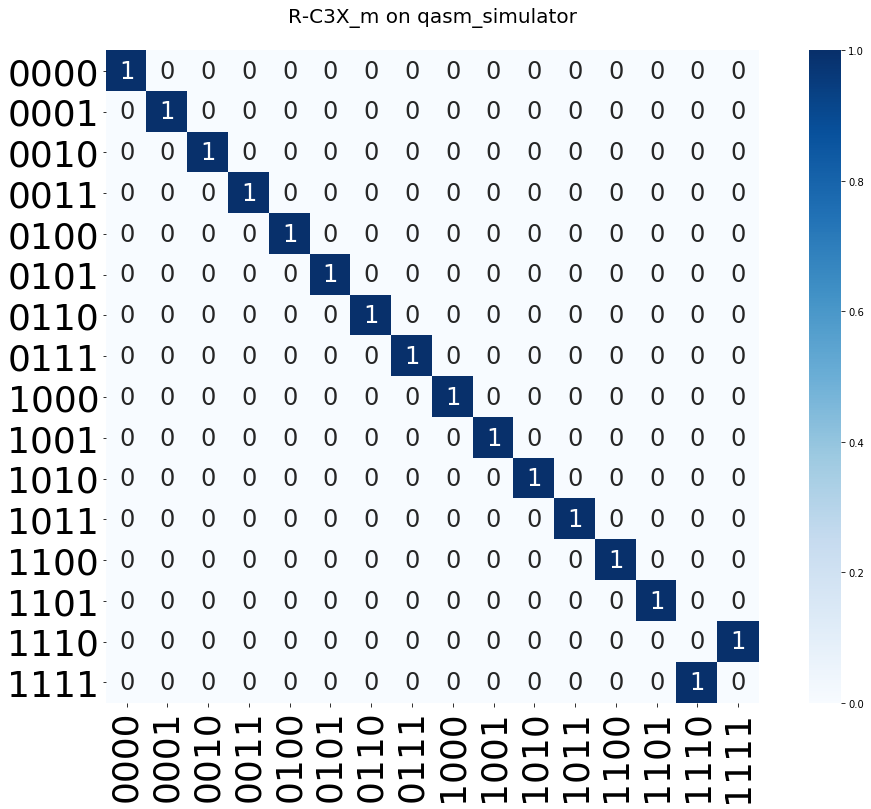

########################## R-C3X_ix ############################


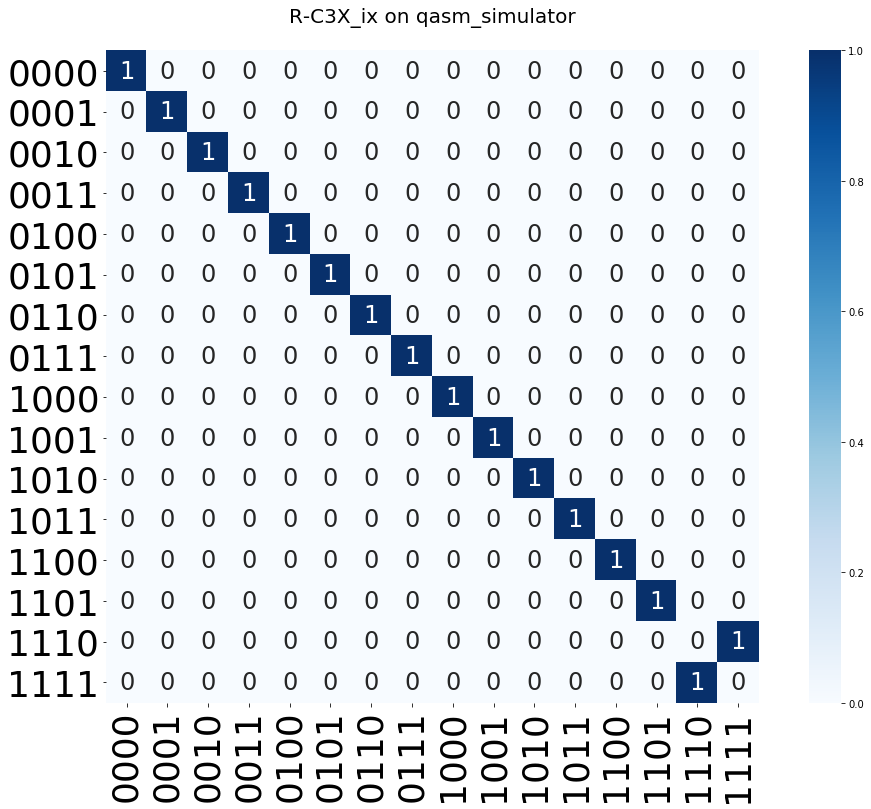

In [16]:
print("########################## R-C3X_m ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(16)]
### labels 
X = [format(num, "04b") for num in range(16)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
plt.title("R-C3X_m on "+str(simulator)+"\n", 
          fontsize=20
         )

## plot data
sns.heatmap(sim_m_data, 
            vmin = 0.0,  ## define maximum value
            vmax=1.0,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues'), ## define the color
            annot_kws={"size": 24}, 
           )

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=36
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=36)

plt.show()

print("########################## R-C3X_ix ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(16)]
### labels 
X = [format(num, "04b") for num in range(16)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
plt.title("R-C3X_ix on "+str(simulator)+"\n", 
          fontsize=20
         )

## plot data
sns.heatmap(sim_ix_data, 
            vmin = 0.0,  ## define maximum value
            vmax=1.0,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues'), ## define the color
            annot_kws={"size": 24}, 
            
           )

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=36
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=36)

plt.show()

---
# 4. Run on Realdevice

In [6]:
backend_monitor(device)

ibmq_valencia
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 0
    backend_version: 1.0.3
    basis_gates: ['u1', 'u2', 'u3', 'cx', 'id']
    local: False
    simulator: False
    allow_q_object: True
    qubit_lo_range: [[4.24450805304576, 5.24450805304576], [4.150717310792668, 5.150717310792668], [4.292324088269334, 5.292324088269334], [4.334116405421784, 5.334116405421784], [4.45934765104631, 5.45934765104631]]
    discriminators: ['linear_discriminator', 'quadratic_discriminator']
    rep_times: [1000]
    hamiltonian: {'description': 'Qubits are modelled as a two level system. Qubits are coupled through resonator buses. The provided Hamiltonian has been projected into the zero excitation subspace of the resonator buses leading to an effective qubit-qubit flip-flop interaction. The qubit resonance frequencies in the Hamiltonian are the cavity dressed frequencies and not exactly what is returned by the backend defaults, whi

In [18]:
a_day = datetime(2020, 1, 6)
backend = provider.backends.ibmq_valencia
prop = backend.properties(datetime=a_day)

_qubit_key_list = list(prop._gates.get('u1').keys())

u2_error_20200101_list = [prop._gates.get('u2').get((0, )).get('gate_error')[0] for qubit in _qubit_key_list]
print('u2_error_20200101_list = ', u2_error_20200101_list)

u3_error_20200101_list = [prop._gates.get('u3').get((0, )).get('gate_error')[0] for qubit in _qubit_key_list]
print('u3_error_20200101_list = ', u3_error_20200101_list)

_cx_key_list = list(prop._gates.get('cx').keys())
cx_error_20200101_list = [prop._gates.get('cx').get(cx_connection).get('gate_error')[0] for cx_connection in _cx_key_list]
print('cx_error_20200101_list = ', cx_error_20200101_list)

u2_error_20200101_list =  [0.00040556182057519674, 0.00040556182057519674, 0.00040556182057519674, 0.00040556182057519674, 0.00040556182057519674]
u3_error_20200101_list =  [0.0008111236411503935, 0.0008111236411503935, 0.0008111236411503935, 0.0008111236411503935, 0.0008111236411503935]
cx_error_20200101_list =  [0.010759105929665974, 0.010759105929665974, 0.012100977655194717, 0.02036213132999834, 0.012100977655194717, 0.02036213132999834, 0.009046288507126687, 0.009046288507126687]


### 4-1. finding the qubit mapping list

In [19]:
## Get qubit coupling map
conf = device.configuration()
coupling_map = conf.coupling_map
print(coupling_map)

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]


In [20]:
## searching the qubit mapping list from coupling_map
from collections import Counter
import copy
    
hub_list = [qubit for qubit, cnt in Counter(np.ravel(coupling_map)).most_common() if cnt>=6]

t_qubit_list = []
for hub in hub_list:
    branch = [con[1] for con in coupling_map if con[0]==hub]
    tale_list = [tale for tale in coupling_map if(tale[1]!=hub and tale[1] not in branch) for bra in branch if(tale[0]==bra)]
    
    tale_mapping_list = []
    for tale in tale_list:
        
        t_list = []
        t_list.append(hub)
        for bra in branch:
            if bra != tale[0]:
                t_list.append(bra)
        t_list.extend(tale)
        tale_mapping_list.append(t_list)
    
    t_qubit_list.append(tale_mapping_list)


qubit_mapping = []
for hub_map in t_qubit_list:
    tale_mapping = []
    for tale_map in hub_map:
        mapping1 = copy.copy(tale_map)
        tale_mapping.append(mapping1)
        
        tale_map[1], tale_map[2] = tale_map[2], tale_map[1]

        mapping2 = copy.copy(tale_map)
        tale_mapping.append(mapping2)
    qubit_mapping.append(tale_mapping)
    
## mitigation mapping


print("qubit_mapping = ", qubit_mapping)

qubit_mapping =  [[[1, 0, 2, 3, 4], [1, 2, 0, 3, 4]]]


In [21]:
qubit_mapping = [[[1, 0, 2, 3, 4], [1, 2, 0, 3, 4]]]
cal_mapping = [[[0, 2, 3, 4], [2, 0, 3, 4]]]

### 4-2. Define mitigation circuit

In [22]:
qr = QuantumRegister(4)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [23]:
print(meas_calibs)
print(state_labels)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1fa47a58>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1fa47b38>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1fa47390>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1fa47470>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1fa472e8>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1fa47550>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1fa47e48>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1faa52b0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1faa54a8>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1faa5898>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1faa56a0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1faa5a58>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1faa5be0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a1faa5e80>, <qisk

### 4-3. Execution

In [24]:
# ## define shots
# shots = 8192

# ## define the lists to store job_id
# job_id_list = []
# cal_job_id_list = []

# # result_exp_list = []
# # result_cal_exp_list = []

# ## repeat # of qubit_mapping times
# for hub, cal_hub in zip(qubit_mapping, cal_mapping):
#     for mapping, cal_map in zip(hub, cal_hub):
    
#         ## job for circuit execution
#         job_exp = execute(RTof_qc,
#                           backend = device,
# #                           backend = simulator,
#                           shots = shots,
#                           initial_layout=mapping,
#                           optimization_level = 0
#                          )
#         job_id_list.append(job_exp.job_id())
#         print('sent the job', mapping)


#         ## job for meas_cal
#         cal_job = execute(meas_calibs, 
#                         backend = device,
# #                           backend = simulator,
#                         shots=shots,
#                         initial_layout=cal_map,
#                         optimization_level=0
#                         )
#         cal_job_id_list.append(cal_job.job_id())
#         print('sent the cal_job', mapping)

# #         ## get results
# #         result_exp = job_exp.result()
# #         result_cal = cal_job.result()

# #         result_exp_list.append(result_exp)
# #         result_cal_exp_list.append(result_cal)

# print('job_id_list = ', job_id_list)
# print('cal_job_id_list = ', cal_job_id_list)

In [25]:
job_id_list =  ['5e12faf8efb76e0011439075', '5e12fb02e7977f001127dcbc']
cal_job_id_list =  ['5e12fafc88f06b001155b0cf', '5e12fb067272e100112de640']

### 4-4. retrieve the job and get the result

In [26]:
        ## Define the list to store the result_exp for error mitigation
result_exp_list = []
result_cal_exp_list = []

for job_id, cal_job_id in zip(job_id_list, cal_job_id_list):
    ## retrieve jobs
    retrieved_job = device.retrieve_job(job_id)
    retrieved_cal_job = device.retrieve_job(cal_job_id)
    print("jobs were retrieved")
    result_exp = retrieved_job.result()
    print("got exp result")
    result_cal_exp = retrieved_cal_job.result()
    print("got cal_exp result")
    ## Append results_exp to the result_exp_list for error mitigation operation
    result_exp_list.append(result_exp)
    result_cal_exp_list.append(result_cal_exp)

print(result_exp_list)
print(result_cal_exp_list)

jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
[Result(backend_name='ibmq_valencia', backend_version='1.0.3', date=datetime.datetime(2020, 1, 6, 12, 59, 50, tzinfo=datetime.timezone.utc), execution_id='106e0b9e-3084-11ea-bbf7-ac1f6b47c318', header=Obj(backend_name='ibmq_valencia', backend_version='1.0.3'), job_id='5e12faf8efb76e0011439075', qobj_id='fd4c7662-b2f8-4117-ba62-d9632b03829e', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=6785, 0x1=505, 0x2=283, 0x3=136, 0x4=214, 0x5=25, 0x6=7, 0x7=2, 0x8=203, 0x9=17, 0xa=7, 0xb=4, 0xc=3, 0xf=1)), header=Obj(clbit_labels=[['c', 0], ['c', 1], ['c', 2], ['c', 3]], creg_sizes=[['c', 4]], memory_slots=4, n_qubits=5, name='circuit0', qreg_sizes=[['q', 5]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4]]), meas_level=2, memory=False, shots=8192, success=True), ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=823, 0x1=6408, 0x2=164, 0x3=282, 0

# Readout Error mitigation

The calibration matrix 

[[9.44702148e-01 4.23583984e-02 5.21240234e-02 2.44140625e-03
  6.46972656e-02 3.78417969e-03 3.29589844e-03 0.00000000e+00
  4.61425781e-02 2.56347656e-03 2.44140625e-03 1.22070312e-04
  3.78417969e-03 0.00000000e+00 1.22070312e-04 0.00000000e+00]
 [1.64794922e-02 9.26025391e-01 6.10351562e-04 4.56542969e-02
  7.32421875e-04 5.73730469e-02 0.00000000e+00 3.78417969e-03
  9.76562500e-04 4.52880859e-02 1.22070312e-04 2.68554688e-03
  1.22070312e-04 2.19726562e-03 0.00000000e+00 1.22070312e-04]
 [1.07421875e-02 4.88281250e-04 9.08325195e-01 4.67529297e-02
  4.88281250e-04 0.00000000e+00 5.59082031e-02 2.80761719e-03
  1.09863281e-03 0.00000000e+00 4.69970703e-02 1.95312500e-03
  0.00000000e+00 0.00000000e+00 3.54003906e-03 1.22070312e-04]
 [1.22070312e-04 7.32421875e-03 1.33056641e-02 8.80493164e-01
  0.00000000e+00 4.88281250e-04 7.32421875e-04 5.71289062e-02
  1.22070312e-04 3.66210938e-04 8.54492188e-04 4.10156250e-02
  0.00000000e+00 0.00000000e+00 1.22070312

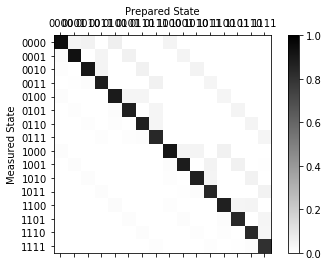

Average Measurement Fidelity: 0.875671 

The calibration matrix 

[[9.50561523e-01 4.76074219e-02 5.02929688e-02 2.56347656e-03
  6.50634766e-02 4.02832031e-03 2.80761719e-03 6.10351562e-04
  4.55322266e-02 3.05175781e-03 1.83105469e-03 1.22070312e-04
  4.51660156e-03 0.00000000e+00 1.22070312e-04 0.00000000e+00]
 [1.03759766e-02 9.15405273e-01 8.54492188e-04 4.52880859e-02
  1.09863281e-03 5.63964844e-02 0.00000000e+00 1.83105469e-03
  1.22070312e-04 4.29687500e-02 0.00000000e+00 1.70898438e-03
  1.22070312e-04 2.80761719e-03 0.00000000e+00 1.22070312e-04]
 [1.31835938e-02 9.76562500e-04 9.14794922e-01 4.46777344e-02
  1.34277344e-03 0.00000000e+00 5.76171875e-02 2.07519531e-03
  6.10351562e-04 0.00000000e+00 4.67529297e-02 1.95312500e-03
  2.44140625e-04 0.00000000e+00 2.68554688e-03 0.00000000e+00]
 [4.88281250e-04 1.30615234e-02 1.08642578e-02 8.83789062e-01
  0.00000000e+00 9.76562500e-04 9.76562500e-04 5.84716797e-02
  0.00000000e+00 6.10351562e-04 4.88281250e-04 4.30908203e-02
 

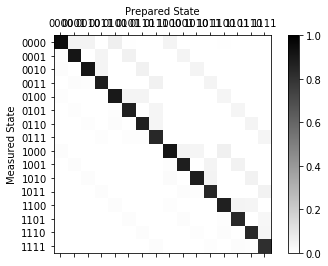

Average Measurement Fidelity: 0.876862 



In [27]:
meas_fitter_list = []

for result_cal_exp in result_cal_exp_list:
    
    ## define measurement fitter
    meas_fitter = CompleteMeasFitter(result_cal_exp, state_labels)
    meas_fitter_list.append(meas_fitter)
    
    print("The calibration matrix \n")
    print(meas_fitter.cal_matrix)

    ## Plot the calibration matrix
    print("Plot the calibration matrix (2D color grid plot)\n")
    meas_fitter.plot_calibration()

    ## The measurement fidelity
    print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity(), "\n")

### Apply device calibration parameter to mitigate the result_exp

In [28]:
## define the list to store 
mitigated_m_list = []
mitigated_ix_list = []

## define repeat length
in_len = len(init_list)

## repeat (num_qubits) times
for result_exp, meas_fitter in zip(result_exp_list, meas_fitter_list):
    
    # Get the filter object
    meas_filter = meas_fitter.filter
    
    ## get measurement error mitigated result
    mitigated_results = meas_filter.apply(result_exp)
    mitigated_m_counts = [mitigated_results.get_counts(init) for init in range(in_len)]
    mitigated_ix_counts = [mitigated_results.get_counts(init) for init in range(in_len, 2*in_len)]
    
    ## Append mitigated_counts to mitigated_list
    mitigated_m_list.append(mitigated_m_counts)
    mitigated_ix_list.append(mitigated_ix_counts)

### Show the mitigated counts

In [29]:
print("mitigated_m_list = ", mitigated_m_list, "\n")
print("mitigated_ix_list = ", mitigated_ix_list, "\n")

mitigated_m_list =  [[{'0011': 146.26450893905357, '0000': 7135.869048758399, '1110': 8.817816268824608e-16, '1111': 0.660156875401566, '0101': 20.390575302708065, '1011': 1.8176253160843348, '1100': 5.116648207556529e-15, '0110': 3.729276002589765e-15, '0001': 408.74175984777776, '1010': 0.8653713571098527, '1000': 106.99332734607603, '1101': 1.9299882872414464e-15, '0100': 143.47542552139237, '1001': 8.140991094029964, '0010': 218.7812096419669}, {'0011': 259.52012840238734, '0000': 551.455884343624, '1111': 3.888728260844493e-16, '0001': 6879.095001278924, '0111': 10.296097326876493, '1000': 1.7230260786790357, '1101': 3.282995144155354, '1001': 92.58335430540858, '0010': 156.41737493032133, '1010': 2.4901015382147365, '1110': 8.062398405145332e-17, '0101': 216.53335327993904, '1011': 3.849872782442953, '1100': 4.3460074677491994e-16, '0110': 4.9337748373988735, '0100': 9.819035751629164}, {'0011': 1022.0561080410872, '0000': 636.7652477063109, '1111': 2.5496195802960204, '0001': 27

### post data processing

In [14]:
mitigated_m_list =  [[{'0011': 146.26450893905357, '0000': 7135.869048758399, '1110': 8.817816268824608e-16, '1111': 0.660156875401566, '0101': 20.390575302708065, '1011': 1.8176253160843348, '1100': 5.116648207556529e-15, '0110': 3.729276002589765e-15, '0001': 408.74175984777776, '1010': 0.8653713571098527, '1000': 106.99332734607603, '1101': 1.9299882872414464e-15, '0100': 143.47542552139237, '1001': 8.140991094029964, '0010': 218.7812096419669}, {'0011': 259.52012840238734, '0000': 551.455884343624, '1111': 3.888728260844493e-16, '0001': 6879.095001278924, '0111': 10.296097326876493, '1000': 1.7230260786790357, '1101': 3.282995144155354, '1001': 92.58335430540858, '0010': 156.41737493032133, '1010': 2.4901015382147365, '1110': 8.062398405145332e-17, '0101': 216.53335327993904, '1011': 3.849872782442953, '1100': 4.3460074677491994e-16, '0110': 4.9337748373988735, '0100': 9.819035751629164}, {'0011': 1022.0561080410872, '0000': 636.7652477063109, '1111': 2.5496195802960204, '0001': 270.42165640449804, '0111': 43.98058617481482, '1000': 3.5432676080144505, '1101': 4.809114261331016e-16, '1001': 0.4437391487348811, '0010': 5975.740357168168, '1010': 64.53054246799823, '1110': 0.8658294334257121, '0101': 7.842631283186353, '1011': 18.93140627005084, '1100': 1.4748266627048756e-15, '0110': 126.10540018839815, '0100': 18.22360852501535}, {'0011': 6163.1607369988715, '0000': 178.54787043872562, '1111': 0.830956016980556, '0001': 624.2371398791979, '0111': 136.36476813107896, '1000': 2.5831584321654028e-14, '1101': 6.853472325242527e-15, '1001': 0.3152864308172868, '0010': 919.0086909504133, '1010': 9.547970507409866, '1110': 2.1944714320567433, '0101': 18.841868587453266, '1011': 85.17250537107458, '1100': 4.3085855521395044e-15, '0110': 47.35175425153137, '0100': 6.425981004387853}, {'0011': 40.76248184720241, '0000': 763.4037570386706, '1111': 4.853490539479659, '0001': 102.29621792354222, '0111': 150.59569221308342, '1000': 151.90389503172028, '1101': 11.953953642266127, '1001': 3.2547782540219283, '0010': 82.66962702555611, '1010': 10.678983556431842, '1110': 7.734531209560459, '0101': 428.1350401201792, '1011': 0.9129642024903363, '1100': 196.59009537745072, '0110': 371.4612561196683, '0100': 5864.793235898676}, {'0011': 47.22914709081873, '0000': 196.83703651737508, '1111': 4.9738000737950125, '0001': 840.6865407875438, '0111': 254.55165700707087, '1000': 21.464348507992646, '1101': 199.51191902040847, '1001': 103.15702840519677, '0010': 41.41138847665118, '1010': 3.6585361101432636, '1110': 7.195694604340792, '0101': 5514.787121097753, '1011': 6.799975345165643, '1100': 37.23611356212507, '0110': 148.9867273874042, '0100': 763.5129660062172}, {'0011': 104.61207715003437, '0000': 65.79364990154602, '1110': 5.59031262308083e-12, '1111': 82.4908087007132, '0101': 238.6257658938551, '1011': 12.267302191496912, '1100': 0.9888809746784751, '0110': 5855.349434299562, '0001': 12.631394409782548, '0111': 826.9782956413003, '1000': 0.39641607095463344, '1101': 6.890470995429138e-13, '0100': 577.341235513583, '1001': 1.567227115228595e-13, '0010': 414.52473925248745}, {'0011': 354.3908290466324, '0000': 6.858929017812912, '1110': 64.39376948292458, '0101': 596.5807879222439, '1100': 0.31979194622284385, '0110': 840.3536472522089, '0001': 42.68840414625221, '1010': 2.650853137904972, '0111': 6050.201982825751, '1000': 0.5226247598123404, '0100': 142.64687248094907, '0010': 90.39150798128743}, {'0011': 43.76854570739071, '0000': 952.9305689864198, '1111': 35.59612514364376, '0001': 65.33517926149533, '0111': 6.686994650019909, '1000': 5396.9291211964755, '1101': 65.27511965391797, '1001': 434.276592516321, '0010': 87.100562366536, '1010': 455.0704198797166, '1110': 32.50554295637882, '0101': 14.867943097553809, '1011': 243.60568913421002, '1100': 303.358710789676, '0110': 11.055520398394764, '0100': 43.63736426185077}, {'0011': 78.79049943966001, '0000': 135.79119237745783, '1111': 24.154509291469356, '0001': 885.0898249857153, '0111': 3.786556381373563, '1000': 780.3732294714409, '1101': 328.3346293734753, '1001': 4948.703946009669, '0010': 36.807248711406636, '1010': 251.94352727833075, '1110': 28.276469840483347, '0101': 60.42261689451367, '1011': 516.6006002518477, '1100': 92.18507542008314, '0110': 2.9216914186129173, '0100': 17.81838285446004}, {'0011': 80.60456063109842, '0000': 81.46286368776235, '1111': 153.64382218872146, '0001': 11.042138492727796, '0111': 30.384275889091633, '1000': 705.7150347346956, '1101': 22.312388226795647, '1001': 87.92293602586537, '0010': 698.7703604968459, '1010': 5330.743473885759, '1110': 269.6984549552173, '0101': 3.337201231032476, '1011': 601.8803812271307, '1100': 48.821659736623666, '0110': 55.38273939170961, '0100': 10.277709198922718}, {'0011': 685.5618961451763, '0000': 12.831891010102984, '1110': 217.35474467840376, '1111': 249.530513194721, '1011': 4951.1166204328465, '1100': 36.45823022146446, '0110': 26.69401215525932, '0001': 94.47751194312147, '1010': 909.7340227318247, '0111': 39.45780131581971, '1000': 133.34728419734466, '1101': 56.32231053215122, '0100': 9.180977864523202, '1001': 662.3579736551809, '0010': 107.57420992205942}, {'0011': 21.17244890562752, '0000': 149.9934309505224, '1111': 159.97616513613, '0001': 37.22497257457869, '0111': 31.38325274472556, '1000': 783.9681455573437, '1101': 439.76991352252094, '1001': 80.02700185703031, '0010': 6.998472084956416, '1010': 38.80061441855861, '1110': 255.64571287685604, '0101': 56.09212313979083, '1011': 35.07885307635807, '1100': 5166.276964735863, '0110': 50.59373690491458, '0100': 878.9981915142248}, {'0011': 3.741940739458426, '0000': 41.17227425513515, '1111': 207.2209254602575, '0001': 167.65381299131013, '0111': 60.5636489981965, '1000': 145.0467575468826, '1101': 4786.287653757468, '1001': 704.2802362513088, '0010': 12.579579475569275, '1010': 17.750536668055823, '1110': 240.01141917594106, '0101': 885.6301482413469, '1011': 35.05090225544457, '1100': 738.2204115617157, '0110': 30.59979818161654, '0100': 116.18995444029262}, {'0011': 16.24014038210208, '0000': 3.313118974724834e-14, '1110': 863.9041407878765, '1111': 5396.8242459988005, '0101': 20.344592737152368, '1011': 397.4111925248423, '1100': 295.22465361674637, '0110': 161.55819388626296, '1010': 148.9760073056043, '0111': 281.47683656290894, '1000': 47.17473094664726, '1101': 479.64518560490086, '0100': 34.729061685906544, '1001': 32.634256124739565, '0010': 15.856761835509458}, {'0011': 23.02988443739928, '0000': 0.9258818683689961, '1111': 949.3171782008152, '0001': 8.693381145155977, '0111': 180.02002902987672, '1000': 26.748692918458982, '1101': 355.0735542556168, '1001': 19.753166707049534, '0010': 5.373622446328254, '1010': 423.9956640165505, '1110': 5307.532640119837, '0101': 32.519121457236324, '1011': 150.3748032375992, '1100': 421.32994787895535, '0110': 274.7723562562339, '0100': 12.540076024517905}], [{'0011': 113.61304774112993, '0000': 7087.419646547872, '1110': 1.684850176042474e-16, '0101': 12.096538236929316, '1011': 3.8288614234754323, '1100': 1.3470857720317664, '0110': 4.692606409139622, '0001': 425.5872409063379, '1010': 2.947276214543317, '0111': 2.9529130722170587, '1000': 100.42384373334238, '0100': 226.139526049015, '1001': 12.842732322860552, '0010': 198.10868157110596}, {'0011': 196.3108804782442, '0000': 419.59525485989536, '1111': 0.944002393219865, '0101': 246.04935234298742, '1011': 0.9209711338747844, '1100': 1.687416680959656, '0110': 5.683745028214068, '0001': 7034.457866802879, '1010': 1.0765107279091268, '0111': 11.47096988266376, '1000': 13.063784766862254, '1101': 4.1994873222697615, '0100': 6.159513681376796, '1001': 124.23475192426032, '0010': 126.1454919743858}, {'0011': 1077.4558552420356, '0000': 579.0977965677603, '1110': 1.053035363871516, '1111': 1.3564724430509267e-15, '0101': 10.90580422654968, '1011': 23.140383472764256, '0110': 159.45169010634032, '0001': 189.04186676512148, '1010': 116.19900945815776, '0111': 31.889398602715325, '1000': 7.737212203906709, '1101': 0.7020603800543374, '0100': 22.463197675011283, '1001': 5.195832144768989, '0010': 5967.666857790941}, {'0011': 6152.48762403075, '0000': 116.15137681506901, '1111': 0.8522312484482396, '0001': 616.8703496352305, '0111': 172.32211229880423, '1000': 1.944672578642128, '1101': 3.3458479042902667e-16, '1001': 5.013563932329947, '0010': 932.4251950981189, '1010': 18.048978823620878, '1110': 2.1818898136647977, '0101': 14.895456739935046, '1011': 116.00612712741093, '1100': 1.6112599535850203e-16, '0110': 42.800421857975884, '0100': 9.583534053142495e-16}, {'0011': 14.172871282847492, '0000': 726.0682106115008, '1111': 18.198157387515696, '0001': 111.41342664169942, '0111': 123.07215264897081, '1000': 71.3369144662861, '1101': 28.33299847244471, '1001': 13.134888253612862, '0010': 53.47031178831668, '1010': 14.15320327608828, '1110': 16.513948676020505, '0101': 321.1918231687816, '1011': 5.083050473667134, '1100': 239.16626544381703, '0110': 285.3002355348148, '0100': 6151.391541873616}, {'0011': 54.91860844627726, '0000': 111.0494109747609, '1111': 8.868751726646394, '0001': 820.0247341257541, '0111': 224.0870527977122, '1000': 15.387977779322835, '1101': 233.34210022862146, '1001': 71.65999816447258, '0010': 29.290710991372283, '1010': 5.174637514137893, '1110': 22.676870713373464, '0101': 5921.550412344483, '1011': 6.301000026838262, '1100': 33.240240939618374, '0110': 121.49420036780243, '0100': 512.9332928588061}, {'0011': 52.95818162745962, '0000': 14.38244663558911, '1111': 74.34923598991409, '0001': 10.775567202099438, '0111': 979.2347718738251, '1000': 1.7844170060432376, '1101': 7.777515892397244, '1001': 7.356248043436514e-14, '0010': 308.7055456434579, '1010': 11.767464842352117, '1110': 2.7296698769060414e-12, '0101': 192.65941963800537, '1011': 8.143354663513547, '1100': 0.6142203406000198, '0110': 5895.396611100416, '0100': 633.4512475443245}, {'0011': 299.90890427099805, '0000': 2.2368066600331244e-14, '1110': 63.74721485315161, '1111': 13.292540788653428, '0101': 561.2118348514872, '1011': 4.127616643755014, '1100': 1.9669837188279695, '0110': 946.5555336467557, '0001': 49.35434648615317, '1010': 4.277204300590553, '0111': 5989.308837879874, '1101': 7.2743951090238905, '0100': 139.82036860431006, '1001': 7.443388175715595e-15, '0010': 111.15421884641931}, {'0011': 42.82358530452354, '0000': 872.4697076641922, '1111': 36.38919880381656, '0001': 68.92892290949581, '0111': 4.232373217273914, '1000': 5304.435097670992, '1101': 57.3491481618074, '1001': 500.8160954143669, '0010': 64.88131920876488, '1010': 397.3536392124522, '1110': 49.877328358571724, '0101': 15.400672393126175, '1011': 306.98510058396226, '1100': 396.4861007871612, '0110': 7.308061586539911, '0100': 66.26364872295339}, {'0011': 81.23790058505548, '0000': 125.31306138951882, '1111': 44.724289964163646, '0001': 868.3983772696037, '0111': 5.03564151488, '1000': 771.1144857423326, '1101': 343.26993970695054, '1001': 5086.298726197207, '0010': 40.886158803433055, '1010': 253.98205752028213, '1110': 12.123562315254693, '0101': 48.399556215727365, '1011': 385.238128615325, '1100': 98.60866830543667, '0110': 4.737653832082858, '0100': 22.63179202274584}, {'0011': 83.50476620531829, '0000': 107.3543714948209, '1111': 164.67098905187828, '0001': 14.86184662072893, '0111': 28.988379244459566, '1000': 712.2438345443679, '1101': 21.626076630314326, '1001': 131.2980177590514, '0010': 672.8940428727474, '1010': 5310.578296149386, '1110': 286.88319779710343, '0101': 1.2891678567182234, '1011': 573.3400592081418, '1100': 51.82496708073508, '0110': 27.639293233406836, '0100': 3.002694250821685}, {'0011': 578.9256511495095, '0000': 19.690894885431426, '1111': 256.1482845000317, '0001': 109.18678248419607, '0111': 39.37025158772022, '1000': 173.7586169594235, '1101': 53.45135427302717, '1001': 657.1498850562812, '0010': 98.22009046732639, '1010': 877.7545609656787, '1110': 179.34054563383992, '0101': 6.800344204794393, '1011': 5055.859415915845, '1100': 43.97425690272626, '0110': 40.306769737337035, '0100': 2.062295276831871}, {'0011': 5.578812932008129, '0000': 93.19479722915791, '1111': 200.21316274585266, '0001': 19.772995797876582, '0111': 25.991631989105965, '1000': 721.4495531958506, '1101': 544.428123537453, '1001': 101.64347975666705, '0010': 10.806524183767701, '1010': 48.72242843635225, '1110': 217.39670837207774, '0101': 54.625597836638676, '1011': 29.480461244433517, '1100': 5347.120060361708, '0110': 15.314107521605786, '0100': 756.261554859445}, {'0011': 6.587122330659089, '0000': 25.422379679679974, '1111': 234.21176975323567, '0001': 111.51141526157147, '0111': 29.5996166001606, '1000': 119.90155438103697, '1101': 5117.889168172338, '1001': 684.886350614081, '0010': 0.20611058507089935, '1010': 49.9923339433579, '1110': 211.8412869888679, '0101': 676.4106000140738, '1011': 57.5834199595262, '1100': 719.2589732158214, '0110': 27.49295454965071, '0100': 119.20494395086754}, {'0011': 7.834805161182422, '0000': 5.2770740178176005, '1111': 5766.487096572783, '0001': 4.3078275889216275, '0111': 278.3088897836994, '1000': 16.098404548720953, '1101': 476.8174429269926, '1001': 11.530237036252561, '0010': 10.412956209386886, '1010': 188.0058839597174, '1110': 772.5916579182391, '0101': 22.944564747177857, '1011': 130.40918285974058, '1100': 329.63325856431703, '0110': 142.74909191452886, '0100': 28.591626190521495}, {'0011': 3.0393977869859095, '0000': 4.170789385774967, '1110': 5583.417747008583, '1111': 981.4124199176126, '0101': 27.528912007121303, '1011': 184.7503621368539, '1100': 356.273230483665, '0110': 325.44749731974343, '1010': 137.93066827296303, '0111': 138.84584663504455, '1000': 16.982466182200902, '1101': 412.3865310119184, '0100': 2.592141182480519, '1001': 9.720929355429218, '0010': 7.501061313622504}]] 
mitigated_ix_list =  [[{'0011': 280.64497999017124, '0000': 6114.341090182146, '1111': 9.963349310654003, '0001': 504.81171346269593, '0111': 45.68977606939342, '1000': 180.17270912883455, '1101': 9.445391722012674, '1001': 19.439543955767025, '0010': 458.37472719589954, '1010': 15.948555289357017, '1110': 12.277424381642453, '0101': 89.29057460742844, '1011': 14.45755419374095, '1100': 44.58947493999298, '0110': 40.73295174925053, '0100': 351.820183821014}, {'0011': 415.4258240858276, '0000': 849.1250371602958, '1111': 5.75672509441484, '0001': 5736.4044951580145, '0111': 37.251892306497865, '1000': 25.746293468088133, '1101': 85.71065018801757, '1001': 175.74402407235334, '0010': 286.84012485003774, '1010': 11.177447635815723, '1110': 6.956593877982988, '0101': 372.32461372593673, '1011': 20.709975589845005, '1100': 19.143104726298958, '0110': 41.808045248553455, '0100': 101.87515281202066}, {'0011': 1028.9261849716565, '0000': 679.5123779883833, '1111': 2.6004826694690157, '0001': 176.76070761254843, '0111': 40.834053262232125, '1000': 3.582267706285496, '1101': 2.208418181399302e-16, '1001': 2.9121445772841397, '0010': 5962.639207216989, '1010': 72.54349143988154, '1110': 3.6924212411700497, '0101': 2.102244308561458, '1011': 18.766623992022055, '1100': 0.09949328483005716, '0110': 176.85373088543506, '0100': 20.17456884325296}, {'0011': 6116.1953170057295, '0000': 165.79100255153747, '1110': 2.3261693647395885, '1111': 0.3568576091315504, '0101': 26.114092665789343, '1011': 85.78692616219926, '0110': 43.26907277921659, '0001': 630.9965223301691, '1010': 8.400473931952995, '0111': 176.40631846003023, '1101': 1.4760980591587043e-15, '0100': 2.992741546183412, '1001': 12.668522013655513, '0010': 920.6959835796656}, {'0011': 32.969135060389895, '0000': 816.1131334690889, '1110': 0.14369334319405103, '1111': 4.213251878532933, '0101': 400.9190966501866, '1011': 2.3367141006595262, '1100': 39.67775430491015, '0110': 258.8786978537096, '0001': 69.2515672101423, '0111': 301.89101882176607, '1000': 5.025497005089709, '1101': 0.2642187308352566, '0100': 6211.315009808039, '1001': 3.56481229571509, '0010': 45.436399467740294}, {'0011': 66.62323417188408, '0000': 39.88309622604686, '1110': 4.353247965526565, '1111': 2.5083574203962633, '0101': 5984.963995227261, '1100': 8.855726180900751, '0110': 296.8963856064558, '0001': 895.1006341229744, '1010': 6.6832388650445, '0111': 316.8921451587601, '1000': 1.237758097094026, '1101': 68.61173461638526, '0100': 457.8456993245794, '1001': 6.385235094887327, '0010': 35.159511921804906}, {'0011': 117.6139090961987, '0000': 40.65075056899605, '1110': 1.2799457850477987e-11, '1111': 74.34337586037636, '0101': 149.2310893270278, '1011': 0.3369626145849114, '1100': 4.817666014386712e-12, '0110': 5905.9520395458885, '0001': 3.112000437346333e-13, '1010': 3.1325092142617876, '0111': 788.532180323419, '0100': 711.5958176743482, '0010': 400.61136577488173}, {'0011': 361.716646783141, '0000': 5.828616957132982e-14, '1110': 94.92520036456249, '1111': 3.7995638526456395e-13, '0101': 580.0680053980876, '1011': 4.248387203828661e-14, '1100': 2.4330694781136417, '0110': 817.41818628329, '0001': 33.9327348750112, '1010': 7.568842122423617, '0111': 6044.9480933447885, '1000': 3.153731839559077e-14, '1101': 3.457122189221328, '0100': 138.87286995080785, '0010': 106.65922921055225}, {'0011': 48.96965898411772, '0000': 908.4388557293714, '1111': 39.1437486439608, '0001': 89.48291102107237, '0111': 14.380528070841967, '1000': 5384.28462775453, '1101': 76.83098290941649, '1001': 401.7209461909603, '0010': 55.39848913082889, '1010': 411.53280318233885, '1110': 41.95716410529881, '0101': 25.12546657041847, '1011': 225.35599983373723, '1100': 331.1129867345577, '0110': 29.428971943100933, '0100': 108.83585919544842}, {'0011': 77.99849010570692, '0000': 139.997062928584, '1111': 36.10406350982776, '0001': 796.5697170987987, '0111': 22.854067619526077, '1000': 792.5873084911422, '1101': 298.6976597194505, '1001': 5008.76504202231, '0010': 36.45297292607521, '1010': 259.78433006376105, '1110': 32.170023523208364, '0101': 102.73687721347994, '1011': 422.94760831585387, '1100': 96.03517993574822, '0110': 22.15121432004539, '0100': 46.1483822064805}, {'0011': 115.331256428984, '0000': 151.65523187307193, '1111': 124.58181787218987, '0001': 12.325106053421363, '0111': 39.787843038860494, '1000': 836.6911579032246, '1101': 17.02933838795346, '1001': 91.66186372537494, '0010': 841.381165849905, '1010': 5308.179291548448, '1110': 129.89751311801638, '0101': 6.616205949948162, '1011': 408.43253220937174, '1100': 24.663001892905204, '0110': 70.58255822858256, '0100': 13.184115919742549}, {'0011': 832.1157382868297, '0000': 32.313588137003876, '1111': 133.95768218635095, '0001': 115.2352330029875, '0111': 63.945612311540465, '1000': 205.2200843330202, '1101': 31.326135391823723, '1001': 666.8314417538616, '0010': 169.84913922981792, '1010': 863.3700151155001, '1110': 199.3230977062187, '0101': 15.964532609968417, '1011': 4805.5253582258365, '1100': 24.43271877232708, '0110': 23.6384943342735, '0100': 8.951128602640036}, {'0011': 2.463310548334245, '0000': 19.918028141097484, '1111': 411.75085667669686, '0001': 2.945981606989993e-14, '0111': 18.986181755864408, '1000': 430.13078628630836, '1101': 347.7055037054443, '1001': 22.65605111643014, '0010': 1.1233859166254884e-15, '1010': 4.328309969146199, '1110': 78.17115937357552, '0101': 27.692904222365133, '1011': 23.184418022001577, '1100': 6300.13130763168, '0110': 10.620924953536726, '0100': 494.2602575975199}, {'0011': 3.4283718439414e-16, '1110': 172.1534416764156, '1111': 153.10422307857172, '0101': 485.90851575104307, '1011': 20.555860862663415, '1100': 329.3556582193645, '0110': 7.112418060851274, '0001': 30.6336112774838, '1010': 8.59508144648366, '0111': 8.806002030972337, '1000': 36.059406700012936, '1101': 6540.658099630764, '0100': 23.889819401251064, '1001': 374.93329997249333, '0010': 0.23456189162989344}, {'0011': 156.60616053578585, '0000': 16.94940718108131, '1111': 4352.964621115105, '0001': 15.65986923869881, '0111': 624.1257195946516, '1000': 69.38317729934805, '1101': 362.02694317154936, '1001': 47.437741288268754, '0010': 50.469008735799825, '1010': 243.59234910007703, '1110': 979.170593571105, '0101': 81.80192524522468, '1011': 483.3665667035203, '1100': 399.3725751421884, '0110': 221.5276065487312, '0100': 87.54573552886409}, {'0011': 50.88226493750936, '0000': 13.750356614168094, '1111': 571.151118371338, '0001': 9.695509073984443, '0111': 199.72053913471302, '1000': 80.50739584007493, '1101': 383.129611966426, '1001': 51.62756873281946, '0010': 126.89402087269485, '1010': 568.3121210699456, '1110': 4678.092682253556, '0101': 80.841738880599, '1011': 187.17966619013853, '1100': 473.36350669067207, '0110': 658.6712874531219, '0100': 58.18061191823953}], [{'0011': 280.1306600561507, '0000': 6237.465345031584, '1111': 7.725081117860661, '0001': 509.01509953582377, '0111': 28.41853478247993, '1000': 118.0536946809081, '1101': 11.464348879235393, '1001': 16.238682002261775, '0010': 442.8347321609863, '1010': 9.395505068247843, '1110': 15.863879123761583, '0101': 55.23572652789937, '1011': 3.113226376468479, '1100': 132.24690310078256, '0110': 27.804935960640282, '0100': 296.9936455949083}, {'0011': 444.09203796870895, '0000': 750.8234135314123, '1111': 11.566421190244322, '0001': 5869.637919600086, '0111': 27.073099609501345, '1000': 25.94594671232273, '1101': 87.39253101959612, '1001': 156.12208258097206, '0010': 275.30619952125403, '1010': 12.112548304727078, '1110': 10.048300915747701, '0101': 348.0179842516365, '1011': 9.041620498694034, '1100': 32.170725335903626, '0110': 32.177188980059476, '0100': 100.4719799791335}, {'0011': 894.7311904958439, '0000': 610.0274311452492, '1111': 0.3486509553091669, '0101': 4.525360359766515, '1011': 15.37305517323791, '1100': 9.936712910829648e-17, '0110': 194.79331566291404, '0001': 162.19254663151452, '1010': 105.12424219068463, '0111': 33.48153002053814, '1000': 8.955504186141033, '1101': 0.9451974525690959, '0100': 1.6893183483203063, '1001': 0.4722991951948693, '0010': 6159.340358182717}, {'0011': 6295.729162232293, '0000': 137.66075620321075, '1111': 2.4533766864501207, '0001': 570.5914874373957, '0111': 176.95289280823874, '1000': 3.2308025071618998, '1101': 0.5731366316913057, '1001': 9.227637664889698, '0010': 835.1150777886361, '1010': 8.26907469254574, '1110': 3.5627039671564864, '0101': 9.40850775547844, '1011': 90.40187502664422, '1100': 0.7676340419646729, '0110': 42.35296830565752, '0100': 5.702906250585024}, {'0011': 31.017312792790534, '0000': 615.230373994993, '1111': 4.616246437237197, '0001': 53.46572181249089, '0111': 281.8066474608792, '1000': 7.200463192540794, '1101': 9.863496733461892, '1001': 0.9223576576343876, '0010': 2.369912062199901, '1010': 1.2513768019723754, '1110': 2.676351436477209e-13, '0101': 467.0734884706459, '1011': 4.866967289254842e-14, '1100': 105.99026597403292, '0110': 255.66297104804076, '0100': 6355.52936556108}, {'0011': 27.72086928121626, '0000': 18.05826670729271, '1110': 10.013921576910663, '1111': 10.317602620949248, '0101': 6270.930688526971, '1100': 10.297118022948117, '0110': 322.81917022555604, '0001': 602.1673906404509, '0111': 334.45152672749913, '1101': 93.46424222931842, '0100': 457.96846064440643, '1001': 1.2397380417347037, '0010': 32.55100475474707}, {'0011': 86.67345339499342, '0000': 22.842247516946564, '1111': 59.96017004908944, '0101': 168.67843417610896, '1011': 9.211263754368494, '1100': 7.7240356873890565, '0110': 6092.448062090185, '0001': 0.23211239080005058, '0111': 829.8030239111882, '1000': 1.4626464136266535e-14, '1101': 5.642613477252443, '0100': 576.4313071246337, '1001': 1.4601479835142226, '0010': 330.8931284435298}, {'0011': 303.283772393066, '0000': 2.041775634100935e-15, '1111': 6.818177151812734, '0001': 33.49224076394849, '0111': 6192.5916431450605, '1000': 2.378049573852732e-15, '1101': 3.0320884293145176, '1001': 1.626352003885903, '0010': 88.23761855626883, '1010': 3.3090714131992733, '1110': 72.50196030091706, '0101': 546.1480522155174, '1011': 0.9953101282811061, '1100': 7.487601258431443, '0110': 783.5424032724005, '0100': 148.93370896789602}, {'0011': 57.89150265610482, '0000': 967.7416220273343, '1110': 41.22348267012201, '1111': 34.977499721429815, '0101': 25.612307154616804, '1011': 346.7421581031111, '1100': 244.96113541314196, '0110': 16.91537914067188, '0001': 106.0873807636232, '1010': 516.9977495289377, '1000': 4995.121660141631, '1101': 43.40829178972987, '0100': 119.45020187978022, '1001': 561.9466951151925, '0010': 112.92293389457373}, {'0011': 96.86805456381444, '0000': 182.0997539371108, '1111': 29.592992942754936, '0001': 925.9856206830859, '0111': 18.136136129987314, '1000': 898.264770520399, '1101': 209.90621706087322, '1001': 4857.2363541983905, '0010': 53.53530376852913, '1010': 230.1858972525903, '1110': 33.38969252756317, '0101': 84.66098072836826, '1011': 447.10811093300987, '1100': 77.71397108540496, '0110': 17.773611038029415, '0100': 29.542532630088562}, {'0011': 99.62629774391412, '0000': 94.22142132557303, '1111': 137.08084006430838, '0001': 21.704398572084756, '0111': 35.622812855968434, '1000': 819.4079900518008, '1101': 14.598833418843064, '1001': 143.05770712499287, '0010': 830.4443052257172, '1010': 5086.6557798844915, '1110': 171.72993557545266, '0101': 8.099061638561682, '1011': 636.7409683884754, '1100': 18.5097169541748, '0110': 60.417169773222135, '0100': 14.082761402418427}, {'0011': 824.7139086526537, '0000': 20.35013603641156, '1111': 152.429562041072, '0001': 102.93903562393608, '0111': 65.83200199887631, '1000': 200.71298572149956, '1101': 41.409333624041615, '1001': 752.4730831367907, '0010': 152.05455450913533, '1010': 768.6419643818766, '1110': 151.2837063033876, '0101': 1.670886186189142, '1011': 4894.400385449287, '1100': 14.839358049483424, '0110': 43.655391415576894, '0100': 4.593706869781355}, {'0011': 7.416471408359937e-15, '0000': 19.977464867797867, '1111': 387.77832078267215, '0001': 8.486809345564783e-15, '0111': 30.12746789598052, '1000': 366.3334928425408, '1101': 355.66814058170013, '1001': 12.068681219468374, '0010': 0.5143071012695953, '1010': 3.297529902368941, '1110': 124.5629714095107, '0101': 19.61322079591887, '1011': 21.874140167306653, '1100': 6405.323100850788, '0110': 1.0823197264635265e-14, '0100': 444.86116158267765}, {'0011': 2.4877899761945044e-14, '0000': 2.484390212816624, '1111': 124.03795883960504, '0001': 15.938398797507322, '0111': 12.883991110515762, '1000': 12.006215664417043, '1101': 6587.403790504384, '1001': 441.290516147248, '0010': 3.461414242327455, '1010': 14.855051299299227, '1110': 196.34887109550883, '0101': 490.73238886721686, '1011': 2.2985404236971894, '1100': 260.71642336980204, '0110': 4.997095353136224, '0100': 22.54495407251841}, {'0011': 133.52006841766638, '0000': 23.762480397618567, '1111': 4405.969124212403, '0001': 19.754564662312454, '0111': 686.8393119919101, '1000': 60.20764550141949, '1101': 494.7311501064779, '1001': 34.025768625028604, '0010': 56.76539186503796, '1010': 215.69334870493688, '1110': 761.463084664758, '0101': 51.455117789431114, '1011': 509.4849367778065, '1100': 425.7216834513498, '0110': 225.03134189943106, '0100': 87.57498093241222}, {'0011': 66.56056029198027, '0000': 6.296125297444972, '1111': 633.8828142743259, '0001': 9.265452977964355, '0111': 158.43689978025296, '1000': 68.12682463879715, '1101': 410.8296467062351, '1001': 67.11315836733579, '0010': 145.200998753517, '1010': 494.5864483948936, '1110': 4642.939434648926, '0101': 78.35572207510229, '1011': 200.63023329795428, '1100': 465.57644994681345, '0110': 668.8238486964104, '0100': 75.37538185204657}]] 

In [16]:
## define length of repeat
input_len = len(mitigated_m_list[0])
output_bin = [format(num, '04b') for num in range(16)]


# mit_m_data = [[[(mitigated_m_list[mapping][inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(len(job_id_list))]
# mit_ix_data = [[[(mitigated_ix_list[mapping][inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(len(job_id_list))]

mit_m_data = [[[mitigated_m_list[mapping][inputvalue].get(outputvalue, 0) for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(2)]
mit_ix_data = [[[mitigated_ix_list[mapping][inputvalue].get(outputvalue, 0) for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(2)]

In [17]:
mean_m = [[(col_0+col_1)/2 for col_0, col_1 in zip(row_0, row_1)] for row_0, row_1 in zip(mit_m_data[0], mit_m_data[1])]

In [18]:
mean_ix = [[(col_0+col_1)/2 for col_0, col_1 in zip(row_0, row_1)] for row_0, row_1 in zip(mit_ix_data[0], mit_ix_data[1])]

In [19]:
print("mean_m = ", mean_m)
print("mean_ix = ", mean_ix)

mean_m =  [[7111.644347653135, 417.16450037705783, 208.44494560653644, 129.93877834009174, 184.80747578520368, 16.24355676981869, 2.346303204569813, 1.4764565361085293, 103.7085855397092, 10.491861708445258, 1.9063237858265847, 2.8232433697798838, 0.6735428860158857, 9.649941436207232e-16, 5.251333222433541e-16, 0.330078437700783], [485.5255696017597, 6956.776434040901, 141.28143345235355, 227.91550444031577, 7.98927471650298, 231.29135281146324, 5.3087599328064705, 10.883533604770125, 7.393405422770645, 108.40905311483445, 1.7833061330619318, 2.3854219581588687, 0.8437083404798282, 3.7412412332125577, 4.031199202572666e-17, 0.4720011966099327], [607.9315221370356, 229.73176158480976, 5971.703607479554, 1049.7559816415614, 20.34340310001332, 9.374217754868017, 142.77854514736924, 37.93499238876507, 5.64023990596058, 2.819785646751935, 90.36477596307799, 21.03589487140755, 7.374133313524378e-16, 0.3510301900271689, 0.959432398648614, 1.2748097901480109], [147.3496236268973, 620.55374475

### Plot the output matrix

In [9]:
## import tools
## Import numpy 
import numpy as np
from numpy import pi

## import plot tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
## To plot heatmap
import seaborn as sns

In [29]:
shots = 8192

mean_m =  [[7111.644347653135, 417.16450037705783, 208.44494560653644, 129.93877834009174, 184.80747578520368, 16.24355676981869, 2.346303204569813, 1.4764565361085293, 103.7085855397092, 10.491861708445258, 1.9063237858265847, 2.8232433697798838, 0.6735428860158857, 9.649941436207232e-16, 5.251333222433541e-16, 0.330078437700783], [485.5255696017597, 6956.776434040901, 141.28143345235355, 227.91550444031577, 7.98927471650298, 231.29135281146324, 5.3087599328064705, 10.883533604770125, 7.393405422770645, 108.40905311483445, 1.7833061330619318, 2.3854219581588687, 0.8437083404798282, 3.7412412332125577, 4.031199202572666e-17, 0.4720011966099327], [607.9315221370356, 229.73176158480976, 5971.703607479554, 1049.7559816415614, 20.34340310001332, 9.374217754868017, 142.77854514736924, 37.93499238876507, 5.64023990596058, 2.819785646751935, 90.36477596307799, 21.03589487140755, 7.374133313524378e-16, 0.3510301900271689, 0.959432398648614, 1.2748097901480109], [147.3496236268973, 620.5537447572142, 925.7169430242661, 6157.824180514811, 3.212990502193927, 16.868662663694156, 45.076088054753626, 154.3434402149416, 0.9723362893210769, 2.664425181573617, 13.798474665515371, 100.58931624924276, 2.2348557737490032e-15, 3.594028557835777e-15, 2.1881806228607705, 0.8415936327143978], [744.7359838250857, 106.85482228262082, 68.0699694069364, 27.467676565024952, 6008.092388886146, 374.6634316444804, 328.3807458272415, 136.83392243102713, 111.6204047490032, 8.194833253817395, 12.416093416260061, 2.998007338078735, 217.8781804106339, 20.143476057355418, 12.124239942790481, 11.525823963497677], [153.94322374606799, 830.355637456649, 35.35104973401173, 51.073877768547995, 638.2231294325117, 5718.168766721118, 135.2404638776033, 239.31935490239152, 18.42616314365774, 87.40851328483467, 4.4165868121405785, 6.5504876860019525, 35.23817725087172, 216.42700962451497, 14.936282658857127, 6.921275900220703], [40.08804826856756, 11.703480805940993, 361.6151424479727, 78.785129388747, 605.3962415289537, 215.64259276593023, 5875.373022699989, 903.1065337575627, 1.0904165384989355, 1.1514259597861232e-13, 5.883732421176059, 10.20532842750523, 0.8015506576392475, 3.8887579461989668, 4.159991249993436e-12, 78.42002234531364], [3.429464508906467, 46.02137531620269, 100.77286341385337, 327.1498666588152, 141.23362054262958, 578.8963113868656, 893.4545904494823, 6019.755410352813, 0.2613123799061702, 3.721694087857798e-15, 3.4640287192477626, 2.063808321877507, 1.1433878325254068, 3.6371975545119453, 64.0704921680381, 6.646270394326714], [912.7001383253059, 67.13205108549556, 75.99094078765043, 43.296065505957124, 54.950506492402084, 15.134307745339992, 9.181790992467338, 5.459683933646912, 5350.682109433734, 467.5463439653439, 426.2120295460844, 275.2953948590862, 349.9224057884186, 61.31213390786269, 41.19143565747527, 35.992661973730165], [130.5521268834883, 876.7441011276594, 38.846703757419846, 80.01420001235775, 20.22508743860294, 54.41108655512052, 3.8296726253478877, 4.4110989481267815, 775.7438576068868, 5017.501336103438, 252.96279239930644, 450.91936443358634, 95.3968718627599, 335.8022845402129, 20.20001607786902, 34.4393996278165], [94.40861759129163, 12.951992556728364, 685.8322016847967, 82.05466341820835, 6.640201724872202, 2.3131845438753498, 41.511016312558226, 29.6863275667756, 708.9794346395317, 109.61047689245838, 5320.660885017573, 587.6102202176362, 50.32331340867937, 21.96923242855499, 278.29082637616034, 159.15740562029987], [16.261392947767206, 101.83214721365877, 102.8971501946929, 632.2437736473429, 5.621636570677536, 3.4001721023971965, 33.500390946298175, 39.41402645176996, 153.55295057838407, 659.7539293557311, 893.7442918487517, 5003.488018174346, 40.21624356209536, 54.88683240258919, 198.34764515612184, 252.83939884737634], [121.59411408984016, 28.498984186227638, 8.902498134362059, 13.375630918817825, 817.6298731868349, 55.35886048821475, 32.953922213260185, 28.68744236691576, 752.7088493765972, 90.83524080684867, 43.761521427455435, 32.27965716039579, 5256.698512548785, 492.09901852998695, 236.5212106244669, 180.09466394099132], [33.297326967407564, 139.5826141264408, 6.392845030320087, 5.1645315350587575, 117.69744919558008, 781.0203741277103, 29.046376365633627, 45.08163279917855, 132.4741559639598, 694.583293432695, 33.87143530570686, 46.31716110748539, 728.7396923887685, 4952.088410964903, 225.9263530824045, 220.71634760674658], [2.6385370089088167, 2.1539137944608138, 13.134859022448172, 12.037472771642252, 31.66034393821402, 21.644578742165113, 152.1536429003959, 279.89286317330414, 31.636567747684104, 22.08224658049606, 168.49094563266084, 263.91018769229146, 312.4289560905317, 478.2313142659467, 818.2478993530578, 5581.655671285792], [2.5483356270719812, 4.346690572577988, 6.437341879975379, 13.034641112192594, 7.566108603499212, 30.024016732178815, 300.1099267879887, 159.43293783246065, 21.86557955032994, 14.737048031239375, 280.96316614475677, 167.56258268722655, 388.8015891813102, 383.7300426337676, 5445.475193564211, 965.364799059214]]
mean_ix =  [[6175.903217606865, 506.91340649925985, 450.60472967844294, 280.387820023161, 324.40691470796116, 72.2631505676639, 34.268943854945405, 37.05415542593667, 149.11320190487132, 17.839112979014402, 12.67203017880243, 8.785390285104715, 88.41818902038777, 10.454870300624034, 14.070651752702018, 8.844215214257332], [799.974225345854, 5803.02120737905, 281.07316218564586, 429.7589310272683, 101.17356639557707, 360.1712989887866, 36.99261711430647, 32.1624959579996, 25.84612009020543, 165.9330533266627, 11.644997970271401, 14.87579804426952, 25.656915031101292, 86.55159060380684, 8.502447396865344, 8.66157314232958], [644.7699045668162, 169.47662712203146, 6060.989782699853, 961.8286877337503, 10.931943595786633, 3.3138023341639866, 185.82352327417453, 37.15779164138513, 6.268885946213264, 1.6922218862395044, 88.83386681528307, 17.06983958262998, 0.04974664241502863, 0.4725987262845481, 1.8462106205850248, 1.4745668123890914], [151.7258793773741, 600.7940048837825, 877.9055306841508, 6205.962239619012, 4.347823898384219, 17.76130021063389, 42.811020542437056, 176.67960563413448, 1.6154012535809499, 10.948079839272605, 8.334774312249367, 88.09440059442174, 0.38381702098233644, 0.28656831584565357, 2.9444366659480377, 1.4051171477908355], [715.671753732041, 61.3586445113166, 23.903155764970098, 31.993223926590215, 6283.4221876845595, 433.99629256041624, 257.27083445087516, 291.84883314132264, 6.112980098815251, 2.2435849766747387, 0.6256884009861877, 1.1683570503297875, 72.83401013947153, 5.063857732148574, 0.07184667159715934, 4.4147491578850655], [28.970681466669784, 748.6340123817126, 33.85525833827599, 47.172051726550166, 457.90707998449295, 6127.947341877116, 309.85777791600594, 325.6718359431296, 0.618879048547013, 3.8124865683110154, 3.34161943252225, 0.0, 9.576422101924434, 81.03798842285184, 7.183584771218614, 6.412980020672756], [31.74649904297131, 0.11605619540018089, 365.75224710920577, 102.14368124559606, 644.0135623994909, 158.95476175156838, 5999.200050818037, 809.1676021173037, 7.313232068133267e-15, 0.7300739917571113, 1.5662546071308938, 4.774113184476702, 3.862017843696937, 2.8213067386262214, 6.3997289252389934e-12, 67.1517729547329], [3.016397260271538e-14, 33.71248781947985, 97.44842388341054, 332.50020958810353, 143.90328945935192, 563.1080288068025, 800.4802947778453, 6118.7698682449245, 1.6957683984721754e-14, 0.8131760019429515, 5.438956767811446, 0.4976550641405743, 4.960335368272542, 3.244605309267923, 83.71358033273978, 3.4090885759065572], [938.0902388783529, 97.78514589234778, 84.16071151270131, 53.430580820111274, 114.14303053761432, 25.368886862517638, 23.172175541886407, 7.1902640354209835, 5189.703143948081, 481.8338206530764, 464.26527635563826, 286.04907896842417, 288.0370610738498, 60.11963734957318, 41.59032338771041, 37.06062418269531], [161.0484084328474, 861.2776688909423, 44.99413834730217, 87.43327233476069, 37.84545741828453, 93.6989289709241, 19.962412679037403, 20.495101874756696, 845.4260395057706, 4933.000698110351, 244.9851136581757, 435.02785962443187, 86.87457551057659, 254.30193839016187, 32.779858025385764, 32.84852822629135], [122.93832659932248, 17.01475231275306, 835.9127355378112, 107.47877708644907, 13.633438661080488, 7.357633794254922, 65.49986400090235, 37.70532794741446, 828.0495739775126, 117.3597854251839, 5197.4175357164695, 522.5867502989236, 21.586359423540003, 15.814085903398261, 150.81372434673452, 130.83132896824912], [26.331862086707716, 109.08713431346179, 160.95184686947664, 828.4148234697417, 6.772417736210695, 8.81770939807878, 33.646942874925195, 64.88880715520838, 202.96653502725988, 709.6522624453262, 816.0059897486883, 4849.962871837562, 19.63603841090525, 36.36773450793267, 175.30340200480316, 143.19362211371146], [19.947746504447675, 1.8973312707732358e-14, 0.2571535506347982, 1.2316552741671263, 469.5607095900988, 23.653062509142003, 5.310462476768368, 24.55682482592246, 398.2321395644246, 17.362366167949258, 3.81291993575757, 22.529279094654115, 6352.727204241234, 351.6868221435722, 101.36706539154311, 399.76458872968453], [1.242195106408312, 23.286005037495563, 1.8479880669786741, 1.2610368473169592e-14, 23.217386736884738, 488.32045230912996, 6.054756706993749, 10.84499657074405, 24.03281118221499, 408.11190805987064, 11.725066372891444, 11.427200643180303, 295.0360407945833, 6564.030945067574, 184.25115638596222, 138.5710909590884], [20.355943789349936, 17.707216950505632, 53.617200300418894, 145.06311447672613, 87.56035823063814, 66.6285215173279, 223.27947422408113, 655.4825157932809, 64.79541140038377, 40.73175495664868, 229.64284890250696, 496.4257517406634, 412.54712929676907, 428.3790466390136, 870.3168391179315, 4379.466872663754], [10.023240955806532, 9.480481025974399, 136.04750981310593, 58.721412614744814, 66.77799688514305, 79.59873047785064, 663.7475680747661, 179.07871945748298, 74.31711023943603, 59.37036355007763, 531.4492847324196, 193.9049497440464, 469.46997831874273, 396.97962933633056, 4660.516058451241, 602.516966322832]]

In [30]:
mean_m = [[round(pro/shots, 3) if pro>0 else 0 for pro in mapping] for mapping in mean_m]
mean_ix = [[round(pro/shots, 3) if pro>0 else 0 for pro in mapping] for mapping in mean_ix]

########################## R-C3X_m ############################


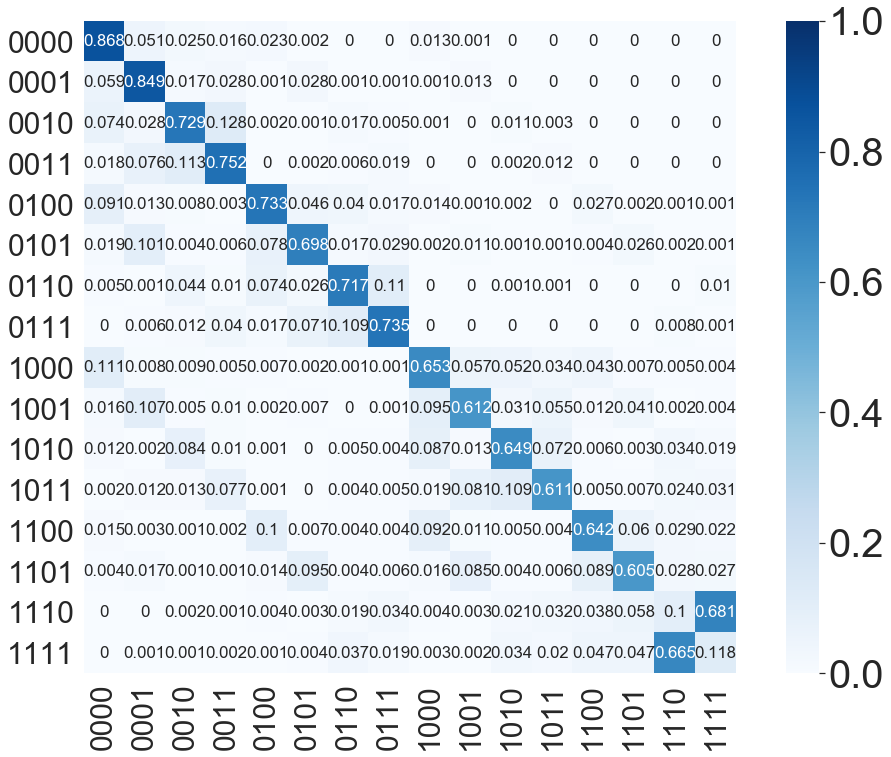

########################## R-C3X_ix ############################


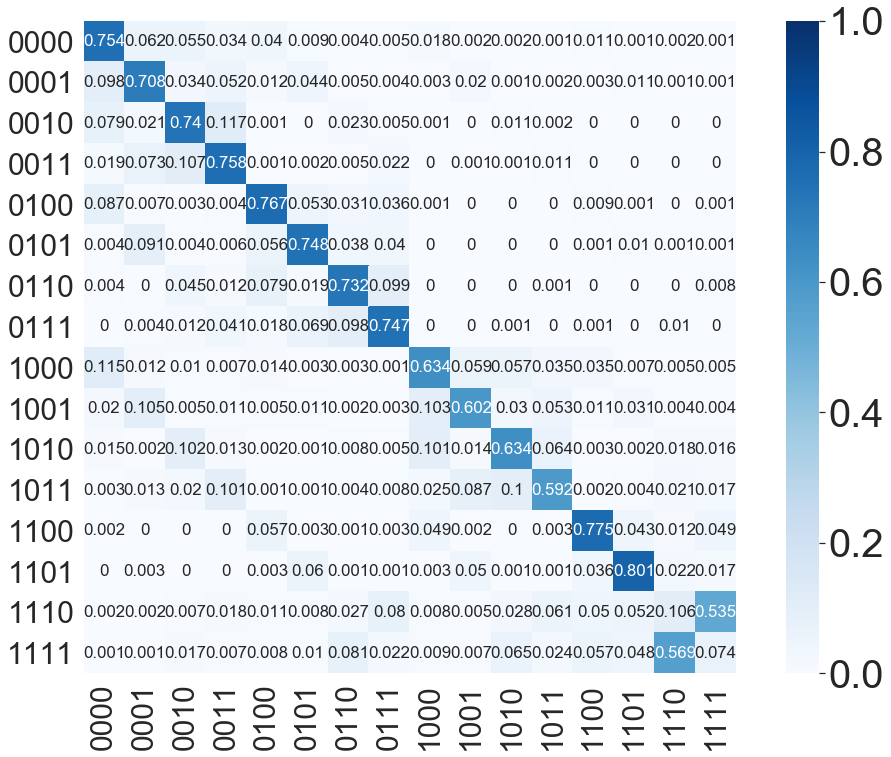

In [33]:
print("########################## R-C3X_m ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(16)]
### labels 
X = [format(num, "04b") for num in range(16)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
# plt.title("R-C3X_m on "+str(device)+"\n", 
#           fontsize=20
#          )

## plot data
sns.set(font_scale=1.4)
sns.heatmap(mean_m, 
            vmin = 0,  ## define maximum value
            vmax=1,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues'), ## define the color
            fmt = 'g',
#             cbar_kws = dict(ticks=[0, 2048, 4096, 6144, 8192])
           )
cax = ax.collections[0].colorbar.ax # ColorbarオブジェクトからカラーバーのAxesオブジェクトにアクセス
# cax = fig.axes[-1] # これでもよい
cax.tick_params(which='minor', direction='in')
cax.tick_params(which='major', labelsize=40)


## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=30,
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=30,
          )


plt.savefig("RC3X_m_valencia_20200106.png", dpi=200, bbox_inches="tight", pad_inches=0.1)
plt.show()

print("########################## R-C3X_ix ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(16)]
### labels 
X = [format(num, "04b") for num in range(16)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
## title
# plt.title("R-C3X_ix on "+str(device)+"\n", 
#           fontsize=20
#          )

## plot data
sns.heatmap(mean_ix, 
            fmt = 'g',
            vmin = 0.0,  ## define maximum value
            vmax=1,   ## defnie minimum value
             annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues'), ## define the color
#             cbar_kws = dict(ticks=[0, 2048, 4096, 6144, 8192])
           )
cax = ax.collections[0].colorbar.ax # ColorbarオブジェクトからカラーバーのAxesオブジェクトにアクセス
# cax = fig.axes[-1] # これでもよい
cax.tick_params(which='minor', direction='in')
cax.tick_params(which='major', labelsize=40)

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=30,
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=30, 
          )
plt.savefig("RC3X_ix_valencia_20200106.png", dpi=200, bbox_inches="tight", pad_inches=0.1)
plt.show()

---
# Check Fidelity

In [36]:
dens_exp_m = [[col/16 for col in row] for row in mean_m]
dens_sim_m = [[col/16 for col in row] for row in sim_m_data]
dens_exp_ix = [[col/16 for col in row] for row in mean_ix]
dens_sim_ix = [[col/16 for col in row] for row in sim_ix_data]

In [37]:
F_m = np.trace(np.sqrt(np.dot(dens_exp_m, dens_sim_m)))
F_ix = np.trace(np.sqrt(np.dot(dens_exp_ix, dens_sim_ix)))
print("F_m = ", F_m, "\n")
print("F_ix = ", F_ix, "\n")

F_m =  0.8050445299328381 

F_ix =  0.8287939373214769 

